In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from copy import deepcopy
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#The first file is uploaded, filtering the Element column to only keep the rows marked as Export Value.
drive.mount('/content/drive')
file_FoodTrade = pd.read_csv('/content/drive/My Drive/Machine Learning/Food trade indicators - FAOSTAT_data_en_2-22-2024.csv')
file_FoodTrade = file_FoodTrade[file_FoodTrade['Element'] == 'Export Value']
#The columns that are not needed from this file are dropped, and the Value column is rename for clarity.
mantener_cols = ['Area', 'Area Code (M49)', 'Year', 'Value']
file_FoodTrade = file_FoodTrade[mantener_cols]
file_FoodTrade =  file_FoodTrade.rename(columns={'Value': 'Export Value'})

Mounted at /content/drive


In [ ]:
#A dictionary is created to keep track of the Area-Area Code relationship, this will be used for the final CSV file.
area_mapping = file_FoodTrade.drop_duplicates(subset=['Area Code (M49)', 'Area']).reset_index(drop=True)
area_dict = pd.Series(area_mapping['Area'].values, index=area_mapping['Area Code (M49)']).to_dict()

In [ ]:
#The second file is uploaded, and the first pivot table is created.
file_CropsProduction = pd.read_csv('/content/drive/My Drive/Machine Learning/Crops production indicators - FAOSTAT_data_en_2-22-2024.csv')
columnas_indices = ['Area', 'Year','Area Code (M49)']
primera_tabla = file_CropsProduction.pivot_table(index=columnas_indices, columns='Item', values='Value', aggfunc='first')
# The word Feature_' is added to the column names, for clarity
primera_tabla.columns = [f'Feature_{col}' for col in primera_tabla.columns]
primera_tabla = primera_tabla.reset_index()


In [ ]:
primera_tabla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4587 entries, 0 to 4586
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Area                                   4587 non-null   object 
 1   Year                                   4587 non-null   int64  
 2   Area Code (M49)                        4587 non-null   int64  
 3   Feature_Cereals, primary               4161 non-null   float64
 4   Feature_Citrus Fruit, Total            3177 non-null   float64
 5   Feature_Fibre Crops, Fibre Equivalent  2699 non-null   float64
 6   Feature_Fruit Primary                  4518 non-null   float64
 7   Feature_Oilcrops, Cake Equivalent      4168 non-null   float64
 8   Feature_Oilcrops, Oil Equivalent       4229 non-null   float64
 9   Feature_Pulses, Total                  3950 non-null   float64
 10  Feature_Roots and Tubers, Total        4495 non-null   float64
 11  Feat

In [ ]:
#The third file has the additional challenge of being split by month while the rest of the files are split by years.
#The mean per year per area is calculated, and it's used to keep the dataset consisten accross files.
file_ConsumerPrices = pd.read_csv('/content/drive/My Drive/Machine Learning/Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv')
file_ConsumerPrices['ValueNew'] = file_ConsumerPrices.groupby(['Year', 'Area','Item'])['Value'].transform('mean')
file_ConsumerPrices.drop(['Months', 'Months Code'], axis=1, inplace=True)
file_ConsumerPrices.drop_duplicates(subset=['Year', 'Area','Item'], keep='first', inplace=True)
#The colum Value is renamed, to keep consistency for the creation of the pivot table.
file_ConsumerPrices = file_ConsumerPrices.rename(columns={'Value': 'PreviousValue'})
file_ConsumerPrices = file_ConsumerPrices.rename(columns={'ValueNew': 'Value'})

In [ ]:
file_ConsumerPrices.head()

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Element Code,Element,Unit,PreviousValue,Flag,Flag Description,Note,Value
0,CP,Consumer Price Indices,4,Afghanistan,2000,2000,23013,"Consumer Prices, Food Indices (2015 = 100)",6125,Value,NaN,24.356332,I,Imputed value,base year is 2015,26.629848
12,CP,Consumer Price Indices,4,Afghanistan,2001,2001,23013,"Consumer Prices, Food Indices (2015 = 100)",6125,Value,NaN,29.944592,I,Imputed value,base year is 2015,29.893548
24,CP,Consumer Price Indices,4,Afghanistan,2002,2002,23013,"Consumer Prices, Food Indices (2015 = 100)",6125,Value,NaN,33.421952,I,Imputed value,base year is 2015,35.344892
36,CP,Consumer Price Indices,4,Afghanistan,2003,2003,23013,"Consumer Prices, Food Indices (2015 = 100)",6125,Value,NaN,39.967661,I,Imputed value,base year is 2015,40.203113
48,CP,Consumer Price Indices,4,Afghanistan,2004,2004,23013,"Consumer Prices, Food Indices (2015 = 100)",6125,Value,NaN,43.401939,I,Imputed value,base year is 2015,45.840561


In [ ]:
#The second pivot table is created, using the same format as the first pivot table
segunda_tabla = file_ConsumerPrices.pivot_table(index=columnas_indices, columns='Item', values='Value', aggfunc='first')
segunda_tabla.columns = [f'Feature_{col}' for col in segunda_tabla.columns]
segunda_tabla = segunda_tabla.reset_index()


In [ ]:
segunda_tabla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4856 entries, 0 to 4855
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Area                                                4856 non-null   object 
 1   Year                                                4856 non-null   int64  
 2   Area Code (M49)                                     4856 non-null   int64  
 3   Feature_Consumer Prices, Food Indices (2015 = 100)  4856 non-null   float64
 4   Feature_Food price inflation                        4653 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 189.8+ KB


In [ ]:
#The fourth file is uploaded
file_LandUse = pd.read_csv('/content/drive/My Drive/Machine Learning/Land use - FAOSTAT_data_en_2-22-2024.csv')
#The third pivot table is created, using the same format as the first pivot table
tercera_tabla = file_LandUse.pivot_table(index=columnas_indices, columns='Item', values='Value', aggfunc='first')
tercera_tabla.columns = [f'Feature_{col}' for col in tercera_tabla.columns]
tercera_tabla = tercera_tabla.reset_index()

In [ ]:
tercera_tabla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9519 entries, 0 to 9518
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Area                                                   9519 non-null   object 
 1   Year                                                   9519 non-null   int64  
 2   Area Code (M49)                                        9519 non-null   int64  
 3   Feature_Agricultural land                              9212 non-null   float64
 4   Feature_Agriculture                                    9212 non-null   float64
 5   Feature_Agriculture area actually irrigated            1083 non-null   float64
 6   Feature_Arable land                                    8960 non-null   float64
 7   Feature_Country area                                   9519 non-null   float64
 8   Feature_Cropland                                

In [ ]:
#The fifth file is uploaded. This file presents the additional challenge of presenting items that don't correspond to crops
#These additional items are removed before the pivot table is created.
file_FoodBalance = pd.read_csv('/content/drive/My Drive/Machine Learning/Food balances indicators - FAOSTAT_data_en_2-22-2024.csv')
values_to_exclude = ['Alcoholic Beverages', 'Eggs', 'Meat', 'Milk - Excluding Butter','Stimulants','Sugar & Sweeteners','Fish, Seafood']
file_FoodBalance = file_FoodBalance[~file_FoodBalance['Item'].isin(values_to_exclude)]


#The fourth pivot table is created, using the same format as the first pivot table
cuarta_tabla = file_FoodBalance.pivot_table(index=columnas_indices, columns='Item', values='Value', aggfunc='first')
cuarta_tabla.columns = [f'Feature_{col}' for col in cuarta_tabla.columns]
cuarta_tabla = cuarta_tabla.reset_index()


In [ ]:
cuarta_tabla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Area                              2176 non-null   object 
 1   Year                              2176 non-null   int64  
 2   Area Code (M49)                   2176 non-null   int64  
 3   Feature_Cereals - Excluding Beer  2176 non-null   float64
 4   Feature_Fruits - Excluding Wine   2176 non-null   float64
 5   Feature_Oilcrops                  2176 non-null   float64
 6   Feature_Pulses                    2176 non-null   float64
 7   Feature_Spices                    2176 non-null   float64
 8   Feature_Starchy Roots             2176 non-null   float64
 9   Feature_Sugar Crops               2028 non-null   float64
 10  Feature_Treenuts                  2172 non-null   float64
 11  Feature_Vegetable Oils            2176 non-null   float64
 12  Featur

In [ ]:
#The sixth file is uploaded
file_Fertilizers = pd.read_csv('/content/drive/My Drive/Machine Learning/Fertilizers use - FAOSTAT_data_en_2-27-2024.csv')

#The fifth pivot table is created, using the same format as the first pivot table
quinta_tabla = file_Fertilizers.pivot_table(index=columnas_indices, columns='Item', values='Value', aggfunc='first')
quinta_tabla.columns = [f'Feature_{col}' for col in quinta_tabla.columns]
quinta_tabla = quinta_tabla.reset_index()

In [ ]:
quinta_tabla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 26 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Area                                                                              1933 non-null   object 
 1   Year                                                                              1933 non-null   int64  
 2   Area Code (M49)                                                                   1933 non-null   int64  
 3   Feature_Ammonia, anhydrous                                                        293 non-null    float64
 4   Feature_Ammonium nitrate (AN)                                                     1125 non-null   float64
 5   Feature_Ammonium sulphate                                                         1316 non-null   float64
 6   

In [ ]:
#The seventh file is uploaded

file_Pesticides = pd.read_csv('/content/drive/My Drive/Machine Learning/Pesticides use - FAOSTAT_data_en_2-27-2024.csv')

#The sixth pivot table is created, using the same format as the first pivot table
sexta_tabla = file_Pesticides.pivot_table(index=columnas_indices, columns='Item', values='Value', aggfunc='first')
sexta_tabla.columns = [f'Feature_{col}' for col in sexta_tabla.columns]
sexta_tabla = sexta_tabla.reset_index()

In [ ]:
sexta_tabla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4636 entries, 0 to 4635
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Area                                    4636 non-null   object 
 1   Year                                    4636 non-null   int64  
 2   Area Code (M49)                         4636 non-null   int64  
 3   Feature_Fungicides and Bactericides     4592 non-null   float64
 4   Feature_Fungicides – Seed treatments    2634 non-null   float64
 5   Feature_Herbicides                      4504 non-null   float64
 6   Feature_Insecticides                    4636 non-null   float64
 7   Feature_Insecticides – Seed Treatments  2371 non-null   float64
 8   Feature_Pesticides (total)              4636 non-null   float64
 9   Feature_Rodenticides                    3910 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 362.3+ KB


In [ ]:
#All the dataframes created from the different files are merged into one, using Area, Year and Area Code as merging criterias
files_combinados = pd.merge(primera_tabla, segunda_tabla, on=['Area', 'Year','Area Code (M49)'], how='outer')
files_combinados = pd.merge(files_combinados, tercera_tabla, on=['Area', 'Year','Area Code (M49)'], how='outer')
files_combinados = pd.merge(files_combinados, cuarta_tabla, on=['Area', 'Year','Area Code (M49)'], how='outer')
files_combinados = pd.merge(files_combinados, quinta_tabla, on=['Area', 'Year','Area Code (M49)'], how='outer')
files_combinados = pd.merge(files_combinados, sexta_tabla, on=['Area', 'Year','Area Code (M49)'], how='outer')

files_combinados = pd.merge(files_combinados, file_FoodTrade, on=['Area', 'Year','Area Code (M49)'], how='outer')

In [ ]:
files_combinados

,Area,Year,Area Code (M49),"Feature_Cereals, primary","Feature_Citrus Fruit, Total","Feature_Fibre Crops, Fibre Equivalent",Feature_Fruit Primary,"Feature_Oilcrops, Cake Equivalent","Feature_Oilcrops, Oil Equivalent","Feature_Pulses, Total",...,Feature_Urea,Feature_Urea and ammonium nitrate solutions (UAN),Feature_Fungicides and Bactericides,Feature_Fungicides – Seed treatments,Feature_Herbicides,Feature_Insecticides,Feature_Insecticides – Seed Treatments,Feature_Pesticides (total),Feature_Rodenticides,Export Value
0,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31080.0
2,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1715.0
3,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10300.0
4,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71630,Zimbabwe,1999,716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219.0
71631,Zimbabwe,1999,716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61083.0
71632,Zimbabwe,1999,716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,569123.0
71633,Zimbabwe,1999,716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0


In [ ]:
files_combinados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71635 entries, 0 to 71634
Data columns (total 77 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Area                                                                              71635 non-null  object 
 1   Year                                                                              71635 non-null  int64  
 2   Area Code (M49)                                                                   71635 non-null  int64  
 3   Feature_Cereals, primary                                                          46568 non-null  float64
 4   Feature_Citrus Fruit, Total                                                       35576 non-null  float64
 5   Feature_Fibre Crops, Fibre Equivalent                                             30906 non-null  float64
 6 

In [ ]:
#The Target column is created, adding the 3 year shift required by the assignment.
files_combinados['Target'] = files_combinados['Export Value'].shift(-3)

In [ ]:
#The NaNs are being considered. The methods used are forward fill and backward fill, taking into consideration that the different
#areas must not informed eachother's data.
for columna in files_combinados.columns:
    if files_combinados[columna].dtype == 'float64' or files_combinados[columna].dtype == 'int64':
        files_combinados[columna] = files_combinados.groupby('Area')[columna].fillna(method='ffill')

for columna in files_combinados.columns:
    if files_combinados[columna].dtype == 'float64' or files_combinados[columna].dtype == 'int64':
        files_combinados[columna] = files_combinados.groupby('Area')[columna].fillna(method='bfill')


In [ ]:
files_combinados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71635 entries, 0 to 71634
Data columns (total 78 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Area                                                                              71635 non-null  object 
 1   Year                                                                              71635 non-null  int64  
 2   Area Code (M49)                                                                   71635 non-null  int64  
 3   Feature_Cereals, primary                                                          65580 non-null  float64
 4   Feature_Citrus Fruit, Total                                                       50574 non-null  float64
 5   Feature_Fibre Crops, Fibre Equivalent                                             45766 non-null  float64
 6 

In [ ]:
# The logarithmic transformation is applied, excluding 'Area Code'. New columns are created, tagged as these transformation
for columna in files_combinados.columns:
    if columna != 'Area Code (M49)' and files_combinados[columna].dtype in ['float64', 'int64'] and '_log' not in columna:
        files_combinados[columna + '_log'] = np.log1p(files_combinados[columna])




In [ ]:
files_combinados.head()

,Area,Year,Area Code (M49),"Feature_Cereals, primary","Feature_Citrus Fruit, Total","Feature_Fibre Crops, Fibre Equivalent",Feature_Fruit Primary,"Feature_Oilcrops, Cake Equivalent","Feature_Oilcrops, Oil Equivalent","Feature_Pulses, Total",...,Feature_Urea and ammonium nitrate solutions (UAN)_log,Feature_Fungicides and Bactericides_log,Feature_Fungicides – Seed treatments_log,Feature_Herbicides_log,Feature_Insecticides_log,Feature_Insecticides – Seed Treatments_log,Feature_Pesticides (total)_log,Feature_Rodenticides_log,Export Value_log,Target_log
0,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,9.239996
1,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.344352,0.000000
2,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.447751,0.000000
3,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.239996,10.207695
4,Afghanistan,2000,4,8063.0,71245.0,3990.0,76730.0,3833.0,2231.0,10203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.802118


In [ ]:
#Feature and Label Selection
#Selecting all the columns tagged as log transformations, plus Area Code
columnas_features_log = [col for col in files_combinados.columns if '_log' in col and col != 'Target_log']
columnas_features_log.append('Area Code (M49)')

# Defining the target column
columna_target_log = ['Target_log']

# Features and target from the DataFrame
features_log = files_combinados[columnas_features_log]
targets_log = files_combinados[columna_target_log]

# Checking the dimensions of the features and Labels
print("Dimensions of features (features_log):", features_log.shape)
print("Dimensions of targets (targets_log):", targets_log.shape)


Dimensions of features (features_log): (71635, 76)
Dimensions of targets (targets_log): (71635, 1)


In [ ]:
#Checking for NaNs again, after the log transformation
print("Missing values per column after logarithmic transformation:")
print(features_log.isnull().sum())
print(targets_log.isnull().sum())



Missing values per column after logarithmic transformation:
Year_log                                          0
Feature_Cereals, primary_log                   6055
Feature_Citrus Fruit, Total_log               21061
Feature_Fibre Crops, Fibre Equivalent_log     25869
Feature_Fruit Primary_log                      2587
                                              ...  
Feature_Insecticides – Seed Treatments_log    39783
Feature_Pesticides (total)_log                 3097
Feature_Rodenticides_log                      14905
Export Value_log                               1680
Area Code (M49)                                   0
Length: 76, dtype: int64
Target_log    1278
dtype: int64


In [ ]:
# Fill missing values in features and targets, and checking again for NaNs
features_log.fillna(method='ffill', inplace=True)
targets_log.fillna(method='ffill', inplace=True)

print("Missing values after filling (features):", features_log.isnull().sum().sum())
print("Missing values after filling (targets):", targets_log.isnull().sum().sum())


Missing values after filling (features): 14866
Missing values after filling (targets): 0


In [ ]:
#Dropping the NaNs that weren't filled by the selected method.
features_log = features_log.dropna()
targets_log = targets_log.dropna()


In [ ]:
# Data Alignment, inner joining the features and labels
data_alineada = features_log.join(targets_log, how='inner')

# Extracting the features and labels back from the aligned data
features_alineados = data_alineada.drop(columns=['Target_log'])
targets_alineados = data_alineada['Target_log']

# Verify alignment by checking the shapes
print("Features shape:", features_alineados.shape)
print("Targets shape:", targets_alineados.shape)

# Continue with your train-test split and scaling
train_features, test_features, train_targets, test_targets = train_test_split(
    features_alineados, targets_alineados, test_size=0.25, train_size=0.75, random_state=1)

train_features, val_features, train_targets, val_targets = train_test_split(
    train_features, train_targets, test_size=0.2, train_size=0.8, random_state=1)

# Scaling the data
scaler = RobustScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)


Features shape: (70151, 76)
Targets shape: (70151,)


In [ ]:
#Checking the total instances per dataset
print("Total instances:", data_alineada.shape)
print("Train features:", train_features.shape)
print("Validation features:", val_features.shape)
print("Test features:", test_features.shape)


Total instances: (70151, 77)
Train features: (42090, 76)
Validation features: (10523, 76)
Test features: (17538, 76)


In [ ]:
# Check again for missing values after all transformations and before training
print("Missing values in training features:", np.isnan(train_features_scaled).sum())
print("Missing values in training targets:", np.isnan(train_targets).sum())



Missing values in training features: 0
Missing values in training targets: 0


In [ ]:
# Extracting indices of test data, to use later for the csv file
test_indices = test_features.index


In [ ]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Model setup
class ThreeLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        super(ThreeLayerMLP, self).__init__()
        self.hidden_l1 = nn.Linear(input_size, hidden_layer_sizes[0])
        self.hidden_l2 = nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])
        self.output_l3 = nn.Linear(hidden_layer_sizes[1], output_size)

    def forward(self, inputs):
        out = torch.relu(self.hidden_l1(inputs))
        out = torch.relu(self.hidden_l2(out))
        return self.output_l3(out)

# Creating datasets for train, validation, and test
train_dataset = CustomDataset(train_features_scaled, train_targets.values)
val_dataset = CustomDataset(val_features_scaled, val_targets.values)
test_dataset = CustomDataset(test_features_scaled, test_targets.values)

# Creating DataLoader for each dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

output_size = 1
input_size = 76
hidden_layer_sizes = [128, 64]
model = ThreeLayerMLP(input_size, hidden_layer_sizes, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

def train_and_validate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, epochs=100):
    best_model = None
    best_epoch = -1
    best_test_r2 = -float('inf')  # To track the best test R^2 for comparison
    best_test_loss = float('inf')  # To track the best test loss for comparison
    learning_rates = []
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                total_val_loss += loss.item()

        val_losses.append(total_val_loss / len(val_loader))

        # Test phase for model evaluation and comparison
        total_test_loss = 0
        test_preds, test_targets = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                total_test_loss += loss.item()
                test_preds.extend(outputs.detach().cpu().numpy())
                test_targets.extend(labels.detach().cpu().numpy())

        avg_test_loss = total_test_loss / len(test_loader)
        test_r2 = r2_score(test_targets, test_preds)
        test_losses.append(avg_test_loss)

        # Checking for improvement based on test R² and save best model
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            best_test_loss = avg_test_loss
            best_model = deepcopy(model)
            best_epoch = epoch + 1
            print(f'Epoch {best_epoch}: New best model saved with Test R^2: {best_test_r2:.4f} and Test Loss: {best_test_loss:.4f}.')

        learning_rates.append(optimizer.param_groups[0]['lr'])
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.5f}, Val Loss: {val_losses[-1]:.5f}, Test Loss: {avg_test_loss:.5f}, Test R^2: {test_r2:.5f}")

    print("Training complete. Best model was found at epoch", best_epoch,
          f"with Test R^2: {best_test_r2:.5f} and Test Loss: {best_test_loss:.5f}")
    return best_model, learning_rates, train_losses, val_losses, test_losses

# Training the model
final_model, learning_rates, train_losses, val_losses, test_losses = train_and_validate(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, epochs=100
)

Epoch 1: New best model saved with Test R^2: 0.5343 and Test Loss: 8.8650.
Epoch 1: Train Loss: 13.06242, Val Loss: 8.80164, Test Loss: 8.86496, Test R^2: 0.53427
Epoch 2: New best model saved with Test R^2: 0.5507 and Test Loss: 8.5406.
Epoch 2: Train Loss: 8.72918, Val Loss: 8.45719, Test Loss: 8.54064, Test R^2: 0.55073
Epoch 3: New best model saved with Test R^2: 0.5532 and Test Loss: 8.5122.
Epoch 3: Train Loss: 8.50196, Val Loss: 8.33288, Test Loss: 8.51224, Test R^2: 0.55316
Epoch 4: New best model saved with Test R^2: 0.5547 and Test Loss: 8.4670.
Epoch 4: Train Loss: 8.39025, Val Loss: 8.37317, Test Loss: 8.46700, Test R^2: 0.55468
Epoch 5: New best model saved with Test R^2: 0.5642 and Test Loss: 8.2990.
Epoch 5: Train Loss: 8.30432, Val Loss: 8.10184, Test Loss: 8.29901, Test R^2: 0.56422
Epoch 6: New best model saved with Test R^2: 0.5668 and Test Loss: 8.2474.
Epoch 6: Train Loss: 8.21806, Val Loss: 8.08066, Test Loss: 8.24742, Test R^2: 0.56682
Epoch 7: New best model sav

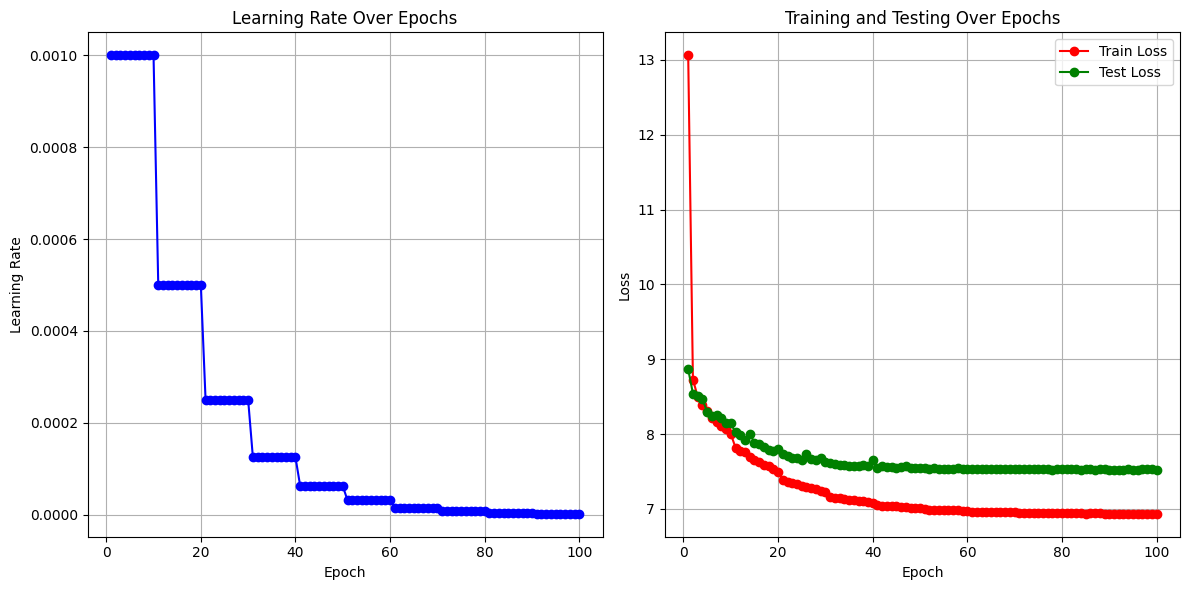

In [ ]:
# Ploting learning rates over epocs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), learning_rates, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.grid(True)

# Ploting losses over epocs
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
plt.plot(range(1, 101), test_losses, label='Test Loss', marker='o', linestyle='-', color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#CSV File creation
test_preds, test_labels = [], []
final_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = final_model(inputs)
        test_preds.extend(outputs.flatten().tolist())
        test_labels.extend(labels.flatten().tolist())

# Converting predictions and true labels that had the log tranformation back to original scale
original_predictions = np.expm1(test_preds)
original_true_labels = np.expm1(test_labels)

# Fetching Year and Area Code from the original DataFrame using test indices
original_year = np.expm1(data_alineada.loc[test_indices, 'Year_log']).astype(int)
area_code = data_alineada.loc[test_indices, 'Area Code (M49)']
data_alineada.loc[test_indices, 'Area Code (M49)'] = data_alineada.loc[test_indices, 'Area Code (M49)'].map(area_dict)
area = data_alineada.loc[test_indices, 'Area Code (M49)']
# Creating the results DataFrame
results_df = pd.DataFrame({
    'Instance ID': test_indices,
    'Year': original_year,
    'Area Code': area_code,
    'Area' : area,
    'True Label (Log)': test_labels,
    'Predicted Label (Log)': test_preds,
    'True Label': original_true_labels,
    'Predicted Label': original_predictions
})
results_df.sort_values(by='Instance ID', inplace=True)

# Saving to CSV
results_csv_path = 'CandNo277229-Outputs.csv'
results_df.to_csv(results_csv_path, index=False)
print("Results saved to", results_csv_path)


Results saved to CandNo277229-Outputs.csv


In [ ]:
files.download('CandNo277229-Outputs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>